# Proyecto Final Riesgo Crediticio

### Objetivos del proyecto

Los objetivos de este proyecto final son:
- identificar las variables que hacen que el solicitante de un préstamo no termine pagando su deuda
- generar un modelo que ayude a predecir si el solicitante de un préstamo pagará o no su deuda 

### Data Acquisition

In [24]:
# Importar librerías

# Operaciones Basicas
import numpy as np
import pandas as pd
import pandas_profiling

# Visualizacion de Datos
import matplotlib.pyplot as plt
import seaborn as sns

# Ocultar los mensajes de advertencia
import warnings
warnings.filterwarnings('ignore')

La fuente de información fue el siguiente dataset de Kaggle: https://www.kaggle.com/datasets/ajay1735/hmeq-data  
Los criterios de selección del dataset fueron la claridad de los datos recolectados y robustez, que facilita el análisis y la generación de un modelo.   
El dataset contiene datos sobre:
- BAD: Categoría de la persona candidata al préstamo. 1, corresponde al candidato con préstamo incumplido o con mora; 0, corresponde al candidato que paga su deuda  
- LOAN: Monto del préstamo solicitado
- MORTDUE: Monto adeudado de la hipoteca existente
- VALUE: Valor del bien o propiedad actual
- REASON: Razón para solicitar el préstamo. DebtCon, corresponde a consolidación de deudas; HomeImp, corresponde a mejoras para el hogar
- JOB: Categoría profesional
- YOJ: Cantidad de años en el trabajo actual
- DEROG: Número de informes derogados o cancelados importantes
- DELINQ: Número de líneas de crédito morosas
- CLAGE: Meses de antigüedad de la línea de crédito de mayor tiempo
- NINQ: Número de consultas crediticas recientes
- CLNO: Número de líneas de crédito


In [25]:
#Leer el dataset
historial_credito = pd.read_csv("hmeq.csv")
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [26]:
#Obtener el tamaño del dataset
print('El dataset tiene ' + str(historial_credito.shape[0]) + ' filas y ' + str(historial_credito.shape[1]) + ' columnas.')

El dataset tiene 5960 filas y 13 columnas.


In [27]:
#Mostrar el tipo de datos
historial_credito.dtypes

BAD          int64
LOAN         int64
MORTDUE    float64
VALUE      float64
REASON      object
JOB         object
YOJ        float64
DEROG      float64
DELINQ     float64
CLAGE      float64
NINQ       float64
CLNO       float64
DEBTINC    float64
dtype: object

In [28]:
#Chequear si hay datos duplicados
historial_credito[historial_credito.duplicated()]

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC


No existen datos duplicados en el dataset.

In [29]:
#Obtener el número de datos nulos y su porcentaje comparado con el total
porcentaje_nulos = historial_credito.isnull().mean().round(4) * 100
pd.merge(historial_credito.isnull().sum().reset_index(), porcentaje_nulos.reset_index(), how='inner', on='index', suffixes=("_Valores Nulos", "_Porcentaje de valores nulos"))


,index,0_Valores Nulos,0_Porcentaje de valores nulos
0,BAD,0,0.00
1,LOAN,0,0.00
2,MORTDUE,518,8.69
3,VALUE,112,1.88
4,REASON,252,4.23
5,JOB,279,4.68
6,YOJ,515,8.64
7,DEROG,708,11.88
8,DELINQ,580,9.73
9,CLAGE,308,5.17


'DEBTINC' es la columna que cuenta con mayor cantidad de valores nulos en un 21.26% de su totalidad

### Data Wrangling

En esta sección prepararemos los datos, limpiándolos y unificándolos en caso de ser necesario para facilitar el acceso, el análisis y el modelado en profundidad.

In [30]:
#Eliminar filas o columnas que no serán utilizadas
historial_credito.drop('DEBTINC', axis=1, inplace=True)
historial_credito.dropna(axis=0, how='any', inplace=True)

- Excluimos del análisis la variable 'DEBTINC' ya que su significado e importancia para el análisis no está claro y además casi un tercio de sus datos son nulos.
- Excluimos del análisis los registros con valores nulos.

Modificaremos las variables 'YOJ' y 'CLAGE' para ganar claridad. Para esto, transformaremos la variable 'YOJ' a una booleana de Empleo o Desempleo y transformaremos la variable 'CLAGE' de meses a años. 

In [31]:
#Utilizar la función lambda
tiene_empleo = lambda x: False if x <=0 else True

#Aplicar la función a la nueva variable
historial_credito['Tiene_Empleo'] = historial_credito.YOJ.apply(tiene_empleo)

#Crear la variable Años_Credito
historial_credito['Años_Credito'] = (historial_credito['CLAGE'] / 12)

#Presentar los resultados
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,Tiene_Empleo,Años_Credito
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,True,7.863889
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,True,10.152778
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,True,12.455556
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,True,7.777778
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,True,8.455500


In [32]:
# Eliminar la variable CLAGE
historial_credito.drop(['CLAGE'], axis=1, inplace=True)
historial_credito.head()


,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,1.0,9.0,True,7.863889
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,0.0,14.0,True,10.152778
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,1.0,10.0,True,12.455556
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,0.0,14.0,True,7.777778
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,1.0,8.0,True,8.455500


In [33]:
#Transformar la variable Tiene_Empleo. Finalizar el Data Wrangling listo para análisis
historial_credito.Tiene_Empleo = historial_credito.Tiene_Empleo.replace({True: 1, False: 0})
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,1.0,9.0,1,7.863889
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,0.0,14.0,1,10.152778
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,1.0,10.0,1,12.455556
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,0.0,14.0,1,7.777778
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,1.0,8.0,1,8.455500


### Análisis Exploratorio de Datos (EDA)

En esta sección se analizan las principales características del conjunto de datos. Definimos a 'BAD' como variable target para dividir el conjunto de datos en submuestras y analizar sus características, la correlación entre variables y el potencial de clasificación.

In [34]:
#Descubrir la cantidad de candidatos morosos y de candidatos que pagan sus deudas
historial_credito.BAD.value_counts()

0    3407
1     840
Name: BAD, dtype: int64

Se observa en base a los datos que 840 candidatos sobre un total de  tienen al menos una deuda morosa. A partir de ahora consideramos 'BAD' como nuestra variable target, recordando que el valor 1 corresponde al candidato con préstamo incumplido o con mora y que el valor 0 corresponde al candidato que paga su deuda.  

#### *Estadísticas descriptivas de candidatos con préstamos pagados*

In [35]:
#Filtrar los préstamos pagados a partir de la variable 'BAD'
historial_credito[historial_credito['BAD']==0].drop('BAD', axis=1).describe().round(4)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito
count,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000,3407.0000
mean,19032.4626,75954.3452,107528.8771,9.3108,0.1048,0.2157,1.0082,22.1256,0.9181,15.3406
std,10863.4585,44495.8932,53831.1805,7.6620,0.3936,0.6059,1.4620,9.1293,0.2742,6.7339
min,1700.0000,2619.0000,26000.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,0.0406
25%,11900.0000,49000.0000,71355.0000,3.0000,0.0000,0.0000,0.0000,16.0000,1.0000,10.1470
50%,16900.0000,67285.0000,94613.0000,8.0000,0.0000,0.0000,1.0000,21.0000,1.0000,15.0609
75%,23800.0000,92693.5000,122328.5000,14.0000,0.0000,0.0000,2.0000,27.0000,1.0000,19.4947
max,89900.0000,371003.0000,471827.0000,36.0000,3.0000,4.0000,11.0000,56.0000,1.0000,54.1456


#### *Estadísticas descriptivas de candidatos con préstamos morosos*

In [36]:
#Filtrar los préstamos morosos a partir de la variable 'BAD'
historial_credito[historial_credito['BAD']==1].drop('BAD', axis=1).describe().round(4)

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito
count,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000,840.0000
mean,16389.4048,68966.4455,97955.4343,7.8549,0.6762,1.1488,1.8440,22.1250,0.9548,12.4777
std,10861.3966,47625.8831,60299.8026,6.8546,1.4318,1.8631,2.2172,11.3532,0.2079,7.3822
min,1100.0000,2800.0000,12500.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,9000.0000,39552.0000,60498.2500,2.5000,0.0000,0.0000,0.0000,14.0000,1.0000,7.8784
50%,14600.0000,59374.5000,83000.0000,6.0000,0.0000,0.0000,1.0000,21.0000,1.0000,11.0011
75%,20650.0000,84985.5000,118031.2500,11.2500,1.0000,2.0000,3.0000,28.0000,1.0000,16.1591
max,77400.0000,399412.0000,512650.0000,41.0000,10.0000,15.0000,13.0000,65.0000,1.0000,97.3528


De las estadísticas descriptivas se pueden comenzar a perfilar algunas definiciones:

- La media de las variables de préstamo solicitado ('LOAN'), importe vencido de la hipoteca ('MORTDUE') y valor de la garantía ('VALUE') es mayor en el caso de las muestras de préstamos PAGADOS. Al tratarse de valores que no son significativamente diferentes, puede no existir un potencial para categorización.

- La media de años en el puesto de trabajo actual ('YOJ') sugiere que los préstamos NO PAGADOS son más frecuentes en los aplicantes con una menor antigüedad en sus trabajos actuales. Esta tendencia se observa también en los cuartiles.

- Luego, se puede observar el caso de las variables relacionadas con el historial crediticio de la persona que solicita el préstamo, como el número de informes derogatorios importantes ('DEROG'), el número de líneas de crédito en mora ('DELINQ'), la antigüedad de la línea de crédito ('CLAGE') y el número de consultas de crédito recientes ('NINQ'). En el caso de los préstamos NO PAGADOS, la distribución de estas variables sugiere un sesgo hacia peores historiales de crédito comparados con la distribución correspondiente para los préstamos PAGADOS.

- Finalmente, el la media de líneas de crédito abiertas ('CLNO') es similar en ambos casos, con lo que tampoco existiría un potencial significativo para categorización.

#### *Análisis Univariado*

#### *Análisis Bivariado*

#### *Análisis Multivariado*

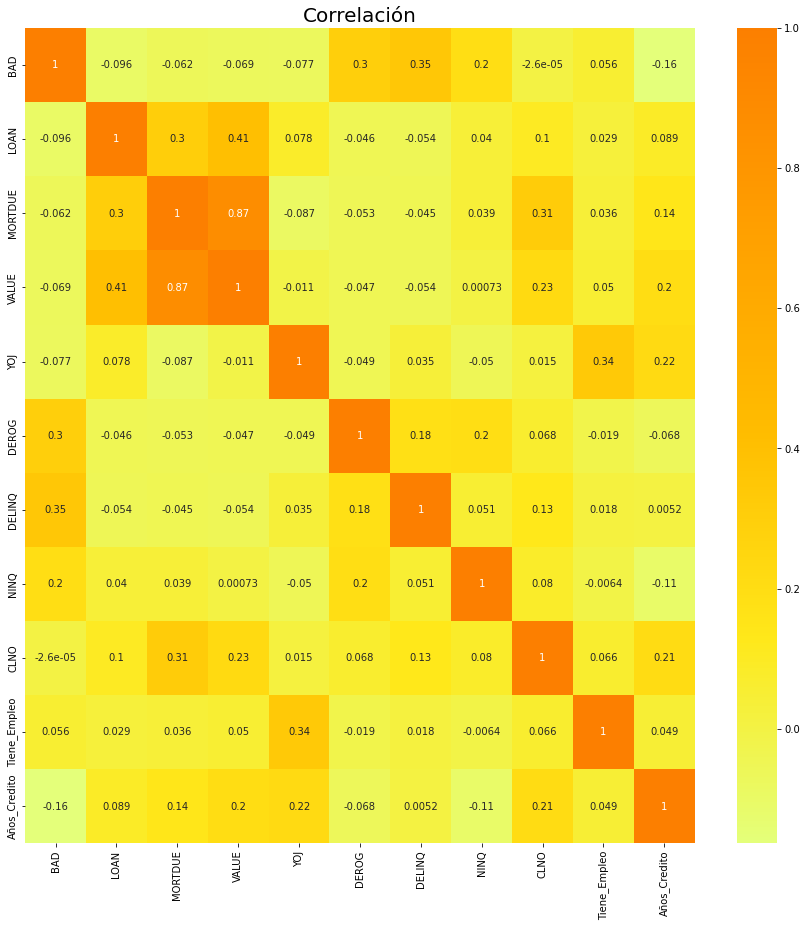

In [44]:
#Heatmap
plt.rcParams['figure.figsize'] = (15, 15)

sns.heatmap(historial_credito.corr(), annot = True, cmap = 'Wistia')
plt.title('Correlación', fontsize = 20)
plt.show()

In [41]:
historial_credito.loc[historial_credito.BAD == 1, 'STATUS'] = 'NO PAGO'
historial_credito.loc[historial_credito.BAD == 0, 'STATUS'] = 'PAGO'
historial_credito.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,NINQ,CLNO,Tiene_Empleo,Años_Credito,STATUS
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,1.0,9.0,1,7.863889,NO PAGO
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,0.0,14.0,1,10.152778,NO PAGO
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,1.0,10.0,1,12.455556,NO PAGO
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,0.0,14.0,1,7.777778,PAGO
5,1,1700,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,1.0,8.0,1,8.455500,NO PAGO
